In [473]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import numpy as np
import random
import operator as op
from functools import reduce
from tqdm import tqdm
import copy
import pickle
from scipy import io
import networkx as nx

In [474]:
A_T= np.zeros((20, 20), dtype=float)
A_T[1::2, ::2] = 1
A_T[::2, 1::2] = 1

In [475]:
#The purpose of this partitioning appears to be part of the Metropolis-Hastings algorithm.
# The binomial coefficien: C(n, r) = n! / (r! * (n - r)!)
def ncr(n, r):  #n choose r
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer // denom  # or / in Python 2

def index_2d(myList, v): #return the exact index
    for i, x in enumerate(myList):
        if v in x:
            return (i, x.index(v))

def l_ij(alpha,beta, A_T,part):       #number of links between group i and j
    link_num = 0
    for a in part[alpha]:
        for b in part[beta]:
            if A_T[a, b] == 1:
                link_num += 1
    return(link_num)


def r_ij(alpha,beta, part):       #maximum possible number of links between group i and j
    return(len(part[alpha]) * len(part[beta]))

In [476]:
def R(i, j, A_T, all_part):   #all_part is a list containing all different partitions
    big_sum= 0
    Z=0
    first_loop_cond = True
    for part in all_part:

        if first_loop_cond:
            gooz_list = [[x,y] for x in range(len(part)) for y in range(len(part)) if len(part[x])<len(part[y])]
            pair_list=[]
            for x in gooz_list:
                if x not in pair_list: pair_list.append(x)

            # H(p) formula
            H_P = 0
            for pair in pair_list:
                alpha, beta = pair
                l = l_ij(alpha, beta, A_T, part)
                r = r_ij(alpha, beta, part)
                h_p = math.log(r+1) + math.log(ncr(r, l))
                H_P += h_p

            Z += np.exp(-H_P)
            first_loop_cond = False
        # print('Pair:',pair,',l:',l,',r:',r,',h_p:',h_p,',H_P:',H_P)


        # define : (l(sigma_i,sigma_j) + 1) / (r(sigma_i,sigma_j) + 2) inside R formula
        sigma_i = index_2d(part, i)[0]
        sigma_j = index_2d(part, j)[0]
        l = l_ij(sigma_i , sigma_j , A_T, part)
        r = r_ij(sigma_i , sigma_j , part)
        parantez = ((l + 1)/(r+2))

        # print(Z)
        big_sum += parantez* np.exp(-H_P)
        R_ij = big_sum/Z
        # print('reliability of i={} and j={}:'.format(i, j), round(R_ij,4))
    return(round(R_ij,5))





In [477]:
# I also define H(P) seperatly because I need it in metropolis function
def H(P,AT_tmp):
    pair_list=[]
    H_P=0
    for i in range(len(P)):
        for j in range(len(P)):
            if i<=j:
                pair_list.append([i,j])
    for pair in pair_list:
            alpha, beta = pair
            l = l_ij(alpha, beta, AT_tmp, P)
            r = r_ij(alpha, beta, P)
            h_p = math.log(r+1) + math.log(ncr(r, l))
            H_P += h_p
    return(H_P)

In [478]:
def Metropolis(T,ens,AT_tmp):#number of iterations (ensemble size)
    e=[] #store result of simulation
    for i in tqdm(range(ens)):
        partitions =  [[i] for i in range(20)].copy()
        c=0
        for kk in range(T):
            partitions = [ele for ele in partitions if ele != []]
            part_before=copy.deepcopy(partitions)

            H0=H(partitions,AT_tmp) #compute hamiltonian
            rpp=random.randint(0,len(partitions)-1)
            m,n=index_2d(partitions,rpp)
            a=partitions[m][n] #select random partition from rpp
            del partitions[m][n] #delete an element at a specific position in a 2D list
            rp=random.randint(0,len(partitions)-1)
            partitions[rp].append(a) #moves (a) to another random partition rp
            Hf=H(partitions,AT_tmp)
            deltaH=Hf-H0 #calculates the change in energy due to move
            if deltaH>0:
                if random.random() > np.exp(-deltaH):
                    partitions=part_before.copy()
        ppp = [ele for ele in partitions if ele != []]
        e.append(ppp)
        #     partitions = [ele for ele in partitions if ele != []]
        #
        # ppp=copy.deepcopy(partitions)
        # e.append(ppp) # The final partitioning is appended to the e list
        print(H(partitions,AT_tmp))
        print(kk)
    return(e)

In [479]:
es = Metropolis(100, 20,A_T)

 45%|████▌     | 9/20 [00:00<00:00, 37.08it/s]

68.2671837489005
99
68.46696143022612
99
76.4601982915411
99
61.593763992240795
99
75.13365134489875
99
61.59376399224081
99
71.15651353704396
99
64.3017717239234
99
81.75146052603972
99
57.58501565377674
99
62.79112007993503
99


100%|██████████| 20/20 [00:00<00:00, 39.27it/s]

69.5566663142511
99
63.997006542945435
99
77.8503377098643
99
69.5566663142511
99
65.84040626254826
99
69.55666631425113
99
68.74376979853058
99
79.55658749896145
99
72.47173346521056
99


In [480]:
def link_remover(A_T, ratio): #adjacency matrix :A_T #the ratio of links to be removed:ratio
    one_index = np.where(A_T==1)
    one_list = [[one_index[0][i], one_index[1][i]] for i in range(len(one_index[0]))]
    r = random.sample(one_list, int(ratio * np.sum(A_T)/2)) #randomly selects a subset of the pairs
    return(r)

#sorting
def Sort(sub_li):
    sub_li.sort(key = lambda x: x[1])
    return sub_li.reverse()

#extract the first element
def Extract(lst):
    return list(list(zip(*lst))[0])

def acc(k):
    zeros=k.count(0)
    ones=k.count(1)
    ef=0
    for i in range(len(k)):
        if k[i]==1:
            ef+=k[i:].count(0)/zeros
    return ef/ones

We are computing the reliability of links that were originally set to zero in the adjacency matrix A_T. The code we've provided iterates through the zero entries in the adjacency matrix and calculates the reliability using the R function.

In [481]:
zero_real = []
zero_index = np.where(A_T==0)

for i in tqdm(range(len(zero_index[0]))):
    #computed reliability for each link is appended to the zero_real list
    zero_real.append(R(zero_index[0][i], zero_index[1][i], A_T, es))

100%|██████████| 200/200 [00:00<00:00, 6269.00it/s]


In [482]:
rat=np.linspace(0.1,1,10) #removal ratio
accs=[]
for r in rat:
    selected_links = link_remover(A_T, r) #select links to remove from the adjacency matrix (based on ratio)
    #Set the selected links to 0 in the adjacency matrix to simulate link removal.
    #print(selected_links)
    for link in selected_links: A_T[link[0], link[1]] = 0 #index 0 and index 1
    #Calculate the reliability of the removed links using the R function and store these values in the zero_fake list.
    zero_fake=[]
    for i in selected_links:
        zero_fake.append(R(i[0], i[1], A_T, es))
    #Print the mean value of the reliabilities of the removed links
    print('the mean value', round(np.mean(zero_fake),2))
    #aggregate all the reliabilities (both real and removed)
    all_real = []
    for i in zero_fake: all_real.append([1, i])
    for i in zero_real: all_real.append([0, i])
    #print(all_real)
    Sort(all_real)
    #print(all_real)
    #print('..............................')
    ext=Extract(all_real)
    #print(ext)
    #calculate the accuracy of the network based on the sorted reliabilities
    accs.append(acc(ext))

the mean value 13.96
the mean value 13.6
the mean value 11.89
the mean value 9.79
the mean value 8.05
the mean value 6.35
the mean value 5.23
the mean value 4.24
the mean value 3.04
the mean value 2.87


#### CONCLUSION:
This information helps us to understand how network reliability changes as we remove links.
Based on these results, it appears that as we remove more links, the mean reliability of the removed links decreases. This is an expected outcome, as removing links reduces the network's overall connectivity and makes it less reliable in terms of link connectivity. The decreasing trend in mean reliability suggests that removing more links has a more significant impact on network reliability.

Text(0.5, 1.0, 'Missing intractions')

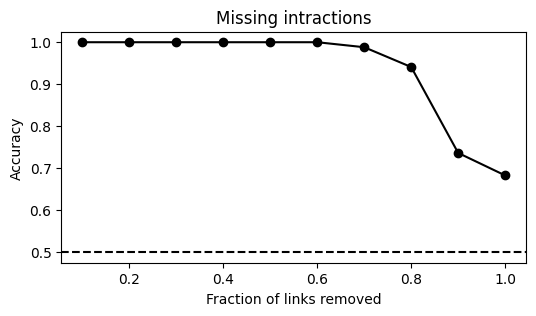

In [483]:
plt.figure(figsize=(6,3))
plt.plot(rat,accs,'-o',color='black')
plt.axhline(y = 0.5, color = 'k', linestyle = '--')
plt.ylabel('Accuracy')
plt.xlabel('Fraction of links removed')
plt.title('Missing intractions')


### Spurious Intercations (Adding Links)

In [484]:
#add links to the adjacency matrix A_T based on a specified ratio
def link_adder(A_T, ratio):
    zero_index = np.where(A_T==0)
    zero_list = [[zero_index[0][i], zero_index[1][i]] for i in range(len(zero_index[0]))]
    r = random.sample(zero_list, int(ratio * np.sum(A_T)/2))
    return(r)

#sorting
def Sort(sub_li):
    sub_li.sort(key = lambda x: x[1])
    return sub_li.reverse()

#extract the first element
#This function is intended to extract the first elements from a list of pairs
def Extract(lst):
    return list(list(zip(*lst))[0])

# def acc(k):
#     zeros=k.count(0)
#     ones=k.count(1)
#     ef=0
#     for i in range(len(k)):
#         if k[i]==1:
#             ef+=k[i:].count(0)/zeros
#     return ef/ones

In [485]:
def acc(k):
    zeros = k.count(0)
    ones = k.count(1)

    if zeros == 0:
        return 0  # Handle the case when there are no zeros (or return another appropriate value)

    ef = 0
    for i in range(len(k)):
        if k[i] == 1:
            ef += k[i:].count(0) / zeros

    return ef / ones

In [486]:
one_real = []
one_index = np.where(A_T==1)#find the indices of one entries in the adjacency matrix

for i in tqdm(range(len(one_index[0]))):
    #computed reliability for each link is appended to the one_real list
    one_real.append(R(one_index[0][i], one_index[1][i], A_T, es))

100%|██████████| 7/7 [00:00<00:00, 7406.69it/s]


In [489]:
rat=np.linspace(0.5,1,10)
accs=[]
for r in rat:
    selected_links = link_adder(A_T, r)
    for link in selected_links: A_T[link[0], link[1]] = 1
    one_fake=[]
    for i in selected_links:
        one_fake.append(R(i[0], i[1], A_T, es))
    print('the mean value', round(np.mean(one_fake),2))
    all_real = []
    for i in one_fake: all_real.append([0, i])
    for i in one_real: all_real.append([1, i])
    Sort(all_real)
    ext=Extract(all_real)
    accs.append(acc(ext))

NameError: name 'A_T_org' is not defined

##### conclusion:
the mean values of the reliabilities for added links as we systematically increased the link addition ratio. This information helps us to understand how network reliability changes as we add more links.it appears that as we add more links to the network, the mean reliability of the added links increases. This suggests that adding more links enhances network reliability. The increasing trend in mean reliability indicates that adding more links has a positive impact on the network's reliability.

Text(0.5, 1.0, 'ُSpurious intractions')

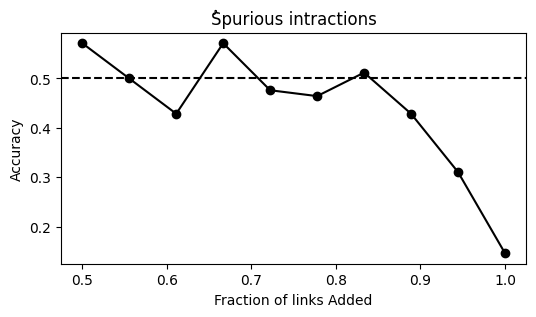

In [488]:
plt.figure(figsize=(6,3))
plt.plot(rat,accs,'-o',color='black')
plt.axhline(y = 0.5, color = 'k', linestyle = '--')
plt.ylabel('Accuracy')
plt.xlabel('Fraction of links Added')
plt.title('ُSpurious intractions')